In [1]:
import glob
import lasio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import binarize
from colorsys import hsv_to_rgb
from random import randint, uniform
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

%matplotlib inline

In [ ]:
wells = glob.glob(r'E:\UT Austin\Datasets\LAS_files\mannville_demo_data\*.las')

uwi =[]
datum = []
ground = []
for well in wells:
    curve = lasio.read(well)
    try:
        da = curve.params['DATM'].value
        gl = curve.params['GL'].value
        u = curve.well['UWI'].value
        
        uwi.append(u)
        datum.append(da)
        ground.append(gl)
    except:
        print('failure')


well_dict = pd.read_csv(r'mann_well_dict.csv')

dataframe = pd.DataFrame({"UWI":uwi, "DATUM":datum, "GL":ground})

new_df = pd.merge(dataframe, well_dict,  how='left', left_on=['UWI'], right_on = ['UWI'])


In [ ]:
tops = pd.read_csv(r"mannvillegrp_picks.csv") #read in the top data
tops.rename(columns={'Pick':'SS'}, inplace=True)

new_df = pd.merge(tops, new_df,  how='left', left_on=['SitID'], right_on = ['SitID'])

not_nullDF = new_df.loc[new_df['UWI'].notnull()]

not_nullDF['TVDSS'] = (not_nullDF.GL-(not_nullDF.DATUM-not_nullDF.SS)).values

In [ ]:
not_nullDF.to_csv('mannville_cleaned.csv')

# Below are the predictions, above is cleaning

In [2]:
tops = pd.read_csv(r"mannville_cleaned.csv", index_col=[0]) #read in the top data
#tops.rename(columns={'TVDSS':'SS'}, inplace=True)

In [3]:
tops.drop(tops[tops.SitID==123627].index.values, inplace=True)
ssmin = tops.TVDSS.min()
tops.TVDSS = tops.TVDSS #- ssmin #standardize the subsea values

tops.dropna(inplace=True)


In [9]:
#tops.drop(['MD', 'GL', 'DELEV', 'DT'], axis=1, inplace=True)
def sample_splitter(dataframe, fraction, randomseed):
    test = dataframe.sample(frac=fraction, random_state=randomseed)
    test_idx = test.index.values
    train =  dataframe.drop(test_idx)
    return train, test

train, test = sample_splitter(tops, 0.2, 91)

print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

D_df = train.pivot_table("TVDSS", "Formation", "SitID").fillna(0)#pivot table to move into sparse matrix land
R = D_df.values
A = binarize(R) 

Training size is 11210 tops, and test size is 2802 tops


In [10]:
print(f'{round((D_df == 0).astype(int).sum().sum()/tops.shape[0], 2)*100} percent of the tops are missing')

67.0 percent of the tops are missing


In [11]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    #print("Initiating ")
    lambda_ = lambda_
    n_factors = n_factors
    n, m = A.shape
    n_iterations = n_iterations
    np.random.seed(86)
    Users = 5 * np.random.rand(n, n_factors, )
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MAE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
     #   print(
     #       "Error after solving for User Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
     #   print(
     #       "Error after solving for Item Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        MAE_List.append(get_error(A, Users, Items, R))
     #   print("%sth iteration is complete..." % iter)
    
   # print(MSE_List)
   # fig = plt.figure()
   # ax = fig.add_subplot(111)
   # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
   # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    return Users, Items

U, Vt = runALS(R, A, 4, 50, 0.1)

recommendations = np.dot(U, Vt) #get the recommendations

recsys = pd.DataFrame(
    data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
) #results

newDF = recsys.T
newDF.reset_index(inplace=True)

flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

new_df = pd.merge(test, flat_preds,  how='left', left_on=['SitID','Formation'], right_on = ['SitID','Formation'])

new_df.rename(columns={0:'SS_pred'}, inplace=True)

cleanDF = new_df.dropna()

cleanDF['signed_error'] = (cleanDF['TVDSS'] - cleanDF['SS_pred'])

print(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))
print(np.sqrt(MSE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin)))

Starting Iterations
8.45422099469491
24.036276321000667


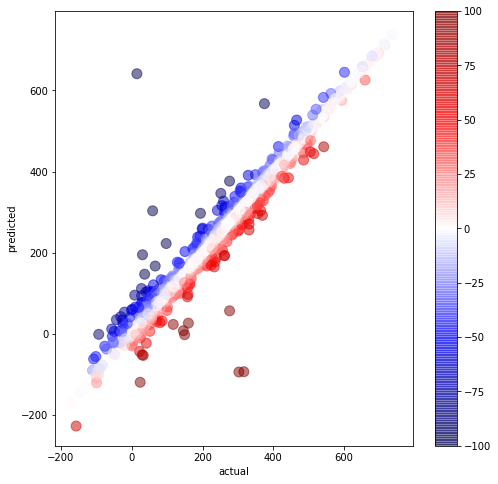

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(cleanDF.TVDSS+ssmin, cleanDF.SS_pred+ssmin, c=cleanDF.signed_error, vmin=-100,vmax=100, 
            cmap='seismic', s=100, alpha=0.5)
plt.plot()
plt.xlabel('actual')
plt.ylabel('predicted')
plt.colorbar()

In [13]:
def cross_validation(dataframe, random_seed, latent_vectors, n_iters):
    np.random.seed(random_seed)
    block_1  = np.random.choice(dataframe.index, size=dataframe.shape[0]//4)
    tops2 = dataframe.drop(block_1)
    block_2 = np.random.choice(tops2.index, size=tops.shape[0]//4)
    tops3 = tops2.drop(block_2)
    block_3 = np.random.choice(tops3.index, size=tops.shape[0]//4)
    tops4 = tops3.drop(block_3)
    block_4 = np.random.choice(tops4.index, size=tops.shape[0]//4)
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    for block in blocks:
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f'Validating on {block.shape[0]} tops')
        D_df = main_group.pivot_table("TVDSS", "Formation", "SitID").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R) 

        
        U, Vt = runALS(R, A, latent_vectors, n_iters, 0.1)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(validate, flat_preds,  how='left', left_on=['SitID','Formation'], right_on = ['SitID','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['TVDSS'] - cleanDF['SS_pred'])

        CV_MAE.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

    return CV_MAE

In [15]:
cross_validation(tops, 86, 4, 200)

Validating on 3503 tops
Starting Iterations
Validating on 3503 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 3503 tops
Starting Iterations
Validating on 3503 tops
Starting Iterations


[9.786857080609016, 9.812743313939622, 10.345148504414682, 9.021499334247872]